# `FL006_hidden_Markov_models` (Frank lab data)

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas

Etienne Ackermann, Sat Dec 02 2017 22:56:52 

CPython 3.5.4
IPython 6.1.0

nelpy 0.1.1
numpy 1.11.3
scipy 0.19.0
pandas 0.21.0


# Overview

We see (qualitatively) more remote replay events when we use the idealized position. In some sense, the idealized position is "more true" than the actual position, since the rat ultimately did find himself on a particular segment of the track, even when the LED was closer to a different segment. Moreover, the idealized position has more robust firing rate estimation, since the binning leads to more observations per location.

It would be awesome if the HMM, which is agnostic to the actual-vs-idealized position considerations, could identify those remote replays that are remote replays in the idealized case, but not in the raw 2D position case. This remains to be seen however, and will take some time to check and quantify comprehensively, so definitely beyond the scope of Asilomar.

**Update:** significance was never determined in 2D :/ so it's unclear whether those events that I'm talking about would be significant or not in 1D. Also, there's a decoding ambiguity in the linearized case, so the 2D approach is more principled imo anyway.

At any rate, for VTC (LSPF) visualization, it might make sense to use a 20 x 20 grid, or so, and to learn it on the idealized position. This way we will have nice, clean, 2D bins.

Using a 50 state model or so is probably better, but 30 states is much faster to train, and since I'm in a time crunch, that is what I'll do initially.

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

%matplotlib inline

warnings.filterwarnings("ignore")

### Load semi-processed Frank Lab data

In [44]:
fileroot = '../../../../neoReader/' 
infile = 'FrankLabData-BonConFra-no-eeg05b.nel' # saved with Pandas=0.21
outfile = 'FrankLabData-BonConFra-no-eeg06d.nel' # saved with Pandas=0.21
FrankLabData = nel.load_pkl(fileroot + infile) 
data = FrankLabData.data
sessions = FrankLabData.sessions

# Train HMM on example Bon Day3 session for initial exploration

Since our goal here is to learn an HMM of E1 run, and then to test E2 SWR sequences, we don't strictly speaking need to use cross validation here. Later on, it might still be good to though.

In [21]:
import nelpy.hmmutils
import nelpy.analysis

num_states = 30
ds_HMM = 0.125 # 500 ms? 

In [22]:
animal, day = 'Bon', 'Day3'

In [23]:
run_epochs = data[animal][day]['run_epochs']
ripple_epochs = data[animal][day]['ripple_epochs']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    st = data[animal][day]['spikes'][[1,3],:] # combine E1a and E1b

if st.isempty: # this is true for Fra Day3 epoch 0
    pass
else:
    # get spiketrain during run bouts for epoch
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        st_run_no_ripples = st[run_epochs][~ripple_epochs]
    bst_training = st_run_no_ripples.bin(ds=ds_HMM)
    # train HMM on E1 combined run data [excluding ripples]
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, verbose=False, n_iter=50)
    print('training HMM...')
    hmm.fit(bst_training)
    print('Done!')

training HMM...
Done!


In [24]:
n_shuffles = 100
# now let's score some events:
bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']

# log prob under HMM with time swap
print('time swap shuffle...')
scores_logprob, scores_tswap_hmm = nel.analysis.replay.score_hmm_timeswap_shuffle(bst=bst, hmm=hmm, n_shuffles=n_shuffles)

# log prob under HMM with transmat shuffle
print('transition matrix shuffle...')
scores_logprob, scores_tmat_shuffled = nel.analysis.replay.score_hmm_transmat_shuffle(bst=bst, hmm=hmm, n_shuffles=n_shuffles)

print('Done!')

time swap shuffle...


KeyboardInterrupt: 

In [29]:
scores = data[animal][day]['remote_replay_E1_in_E2']['logprobs']
tswap = data[animal][day]['remote_replay_E1_in_E2']['scores_tswap_hmm']

pdf saved successfully...
png saved successfully...


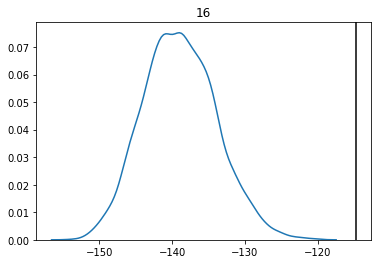

In [42]:
evt_idx = 16
sns.distplot(tswap[:,evt_idx], hist=False)
plt.vlines(scores[evt_idx], 0,1)
plt.title(evt_idx)
npl.savefig('hmm-tswap-{}'.format(evt_idx))

### Augment data dict with HMMs, and with scoring results [first remote, then local]

In [8]:
n_shuffles = 10000

for animal, day in sessions:
    print(animal, day)
    
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']
    except KeyError:
        print('The (animal, day) pair does not have remote replay analysis results; skipping...')
        continue
        
    run_epochs = data[animal][day]['run_epochs']
    ripple_epochs = data[animal][day]['ripple_epochs']
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        st = data[animal][day]['spikes'][[1,3],:] # combine E1a and E1b

    if st.isempty: # this is true for Fra Day3 epoch 0
        pass
    else:
        # get spiketrain during run bouts for epoch
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            st_run_no_ripples = st[run_epochs][~ripple_epochs]

        # train HMM on E1 combined run data [excluding ripples]
        bst_training = st_run_no_ripples.bin(ds=ds_HMM)
        # train HMM on E1 combined run data [excluding ripples]
        hmm = nel.hmmutils.PoissonHMM(n_components=num_states, verbose=False, n_iter=50)
        print('training HMM...')
        hmm.fit(bst_training)
        data[animal][day]['HMM_E1'] = hmm
        
        # score events
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']
        
        print('time swap shuffle...')
        scores_logprob, scores_tswap_hmm = nel.analysis.replay.score_hmm_timeswap_shuffle(bst=bst, hmm=hmm, n_shuffles=n_shuffles)

        # log prob under HMM with transmat shuffle
        print('transition matrix shuffle...')
        scores_logprob, scores_tmat_shuffled = nel.analysis.replay.score_hmm_transmat_shuffle(bst=bst, hmm=hmm, n_shuffles=n_shuffles)
        
        data[animal][day]['remote_replay_E1_in_E2']['logprobs'] = scores_logprob
        data[animal][day]['remote_replay_E1_in_E2']['scores_tswap_hmm'] = scores_tswap_hmm
        data[animal][day]['remote_replay_E1_in_E2']['scores_tmat_shuffled'] = scores_tmat_shuffled


Bon Day2
training HMM...
time swap shuffle...
transition matrix shuffle...
Bon Day3
training HMM...
time swap shuffle...
transition matrix shuffle...
Bon Day4
training HMM...
time swap shuffle...
transition matrix shuffle...
Bon Day5
training HMM...
time swap shuffle...
transition matrix shuffle...
Bon Day6
training HMM...
time swap shuffle...
transition matrix shuffle...
Bon Day7
training HMM...
time swap shuffle...
transition matrix shuffle...
Bon Day8
training HMM...
time swap shuffle...
transition matrix shuffle...
Bon Day9
training HMM...
time swap shuffle...
transition matrix shuffle...
Con Day0
The (animal, day) pair does not have remote replay analysis results; skipping...
Con Day1
The (animal, day) pair does not have remote replay analysis results; skipping...
Con Day2
The (animal, day) pair does not have remote replay analysis results; skipping...
Con Day3
training HMM...
time swap shuffle...
transition matrix shuffle...
Con Day4
training HMM...
time swap shuffle...
transitio

In [ ]:
n_shuffles = 10000

for animal, day in sessions:
    print(animal, day)
    
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_local_candidates']
    except KeyError:
        print('The (animal, day) pair does not have remote replay analysis results; skipping...')
        continue
        
    run_epochs = data[animal][day]['run_epochs']
    ripple_epochs = data[animal][day]['ripple_epochs']
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        st = data[animal][day]['spikes'][[5],:] # use E2

    if st.isempty: # this is true for Fra Day3 epoch 0
        pass
    else:
        # get spiketrain during run bouts for epoch
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            st_run_no_ripples = st[run_epochs][~ripple_epochs]

        # train HMM on E2 run data [excluding ripples]
        bst_training = st_run_no_ripples.bin(ds=ds_HMM)
        # train HMM on E1 combined run data [excluding ripples]
        hmm = nel.hmmutils.PoissonHMM(n_components=num_states, verbose=False, n_iter=50)
        print('training HMM...')
        hmm.fit(bst_training)
        data[animal][day]['HMM_E2'] = hmm
        
        # score events
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_local_candidates']
        
        print('time swap shuffle...')
        scores_logprob, scores_tswap_hmm = nel.analysis.replay.score_hmm_timeswap_shuffle(bst=bst, hmm=hmm, n_shuffles=n_shuffles)

        # log prob under HMM with transmat shuffle
        print('transition matrix shuffle...')
        scores_logprob, scores_tmat_shuffled = nel.analysis.replay.score_hmm_transmat_shuffle(bst=bst, hmm=hmm, n_shuffles=n_shuffles)
        
        data[animal][day]['remote_replay_E1_in_E2']['logprobs_local'] = scores_logprob
        data[animal][day]['remote_replay_E1_in_E2']['scores_tswap_hmm_local'] = scores_tswap_hmm
        data[animal][day]['remote_replay_E1_in_E2']['scores_tmat_shuffled_local'] = scores_tmat_shuffled


Bon Day2
training HMM...
time swap shuffle...
transition matrix shuffle...


### Augment data dict with VTCs/LSPFs

In [ ]:
ds_HMM = 0.125
ds_25ms = 0.025

In [ ]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols

In [ ]:
def append_ASAs(a, b):
    """Very dumb append; does not check for overlaps or anything... use at your own risk!"""
    c = nel.AnalogSignalArray(empty=True)
    c._ydata = np.hstack((a.ydata, b.ydata))
    c._fs = a.fs
    c._time = np.hstack((a.time, b.time))
    c._support = a.support + b.support
    
    return c

In [ ]:
def get_vtc2d(hmm, bst, pos, nx=20, ny=20):
    
    num_states = hmm.n_components
    xpos, ypos = pos.asarray(at=bst.centers).yvals
    
    ext_xmin, ext_xmax = np.floor(pos[:,0].min()/10)*10-1, np.ceil(pos[:,0].max()/10)*10+1
    ext_ymin, ext_ymax = np.floor(pos[:,1].min()/10)*10-1, np.ceil(pos[:,1].max()/10)*10+1
    
    xx_left = np.linspace(ext_xmin, ext_xmax, nx+1)
    xx_mid = np.linspace(ext_xmin, ext_xmax, nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2
    yy_left = np.linspace(ext_ymin, ext_ymax, ny+1)
    yy_mid = np.linspace(ext_ymin, ext_ymax, ny+1)[:-1]; yy_mid += (yy_mid[1]-yy_mid[0])/2

    ext_y = np.digitize(ypos, yy_left) - 1 # spatial bin numbers
    ext_x = np.digitize(xpos, xx_left) - 1

    t = np.zeros(len(xpos), dtype=np.float)

    for ii, (x, y) in enumerate(zip(ext_x, ext_y)):
        t[ii] = sub2ind((nx, ny), x, y)

    t[t==0] = np.nan
    t[t>=nx*ny] = np.nan

    extern = hmm.fit_ext(X=bst, ext=t, n_extern=nx*ny)
    # transform into ratemap shape
    tmp = np.reshape(extern, (num_states, nx, ny))
    vtc_ratemap = np.transpose(tmp, (0,2,1)) # for images, we have (y,x) <==> (r,c) coordinates

    vtc2d = nel.TuningCurve2D(ratemap=vtc_ratemap, min_duration=0, ext_xmin=ext_xmin, ext_xmax=ext_xmax, ext_ymin=ext_ymin, ext_ymax=ext_ymax)
#     vtc2d = vtc2d.smooth(sigma=sigma_tc)
    vtc2d._initialize_mask_from_extern(pos)
    
    return vtc2d    

In [ ]:
sigma_spk = 0.3 # 300 ms spike smoothing

for animal, day in sessions:
    print(animal, day)
    
    try:
        hmmE1 = data[animal][day]['HMM_E1']
        hmmE2 = data[animal][day]['HMM_E2']
    except KeyError:
        print('The (animal, day) pair does not have an HMM; skipping...')
        continue
        
    run_epochs = data[animal][day]['run_epochs']
    ripple_epochs = data[animal][day]['ripple_epochs']
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        st = data[animal][day]['spikes'][[1,3],:] # use E1 and E3 combined

    if st.isempty: # this is true for Fra Day3 epoch 0
        pass
    else:
        # get spiketrain during run bouts for epoch
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            st_run_no_ripples = st[run_epochs][~ripple_epochs]
            
        # smooth and re-bin:
        bst = st_run_no_ripples.bin(ds=ds_25ms).smooth(sigma=sigma_spk, inplace=True).rebin(w=ds_HMM/ds_25ms)

        # we use the idealized position (2D) to learn the place fields...
        pos = append_ASAs(data[animal][day]['pos_ideal'][1], data[animal][day]['pos_ideal'][3])
        
        vtc2d = get_vtc2d(hmm=hmmE1, bst=bst, pos=pos)     
        data[animal][day]['VTC_E1'] = vtc2d
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        st = data[animal][day]['spikes'][[5],:] # use E2

    if st.isempty: # this is true for Fra Day3 epoch 0
        pass
    else:
        # get spiketrain during run bouts for epoch
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            st_run_no_ripples = st[run_epochs][~ripple_epochs]
            
        # smooth and re-bin:
        bst = st_run_no_ripples.bin(ds=ds_25ms).smooth(sigma=sigma_spk, inplace=True).rebin(w=ds_HMM/ds_25ms)

        # we use the idealized position (2D) to learn the place fields...
        pos = data[animal][day]['pos_ideal'][5]
        
        vtc2d = get_vtc2d(hmm=hmmE2, bst=bst, pos=pos)     
        data[animal][day]['VTC_E2'] = vtc2d

### Augment data dict with HMM event p-vals

In [45]:
from scipy import stats

for animal, day in sessions:
    print(animal, day)
    
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_local_candidates']
    except KeyError:
        print('The (animal, day) pair does not have remote replay analysis results; skipping...')
        continue
        
    scores = data[animal][day]['remote_replay_E1_in_E2']['logprobs']
    shuffle_dists = data[animal][day]['remote_replay_E1_in_E2']['scores_tswap_hmm'].T
        
    pvals = []
    for score, shuffle_dist in zip(scores, shuffle_dists):
        pval = (100 - stats.percentileofscore(shuffle_dist, score)) / 100
        pvals.append(pval)
    
    data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_hmm'] = np.array(pvals)
    
    try:
        scores = data[animal][day]['remote_replay_E1_in_E2']['logprobs_local']
        shuffle_dists = data[animal][day]['remote_replay_E1_in_E2']['scores_tswap_hmm_local'].T

        pvals = []
        for score, shuffle_dist in zip(scores, shuffle_dists):
            pval = (100 - stats.percentileofscore(shuffle_dist, score)) / 100
            pvals.append(pval)

        data[animal][day]['remote_replay_E1_in_E2']['pvals_local_hmm'] = np.array(pvals)
    except:
        pass
    


Bon Day2
Bon Day3
Bon Day4
Bon Day5
Bon Day6
Bon Day7
Bon Day8
Bon Day9
Con Day0
The (animal, day) pair does not have remote replay analysis results; skipping...
Con Day1
The (animal, day) pair does not have remote replay analysis results; skipping...
Con Day2
The (animal, day) pair does not have remote replay analysis results; skipping...
Con Day3
Con Day4
Con Day5
Fra Day1
Fra Day2
The (animal, day) pair does not have remote replay analysis results; skipping...
Fra Day3
The (animal, day) pair does not have remote replay analysis results; skipping...
Fra Day4
The (animal, day) pair does not have remote replay analysis results; skipping...
Fra Day5
Fra Day6
The (animal, day) pair does not have remote replay analysis results; skipping...
Fra Day7
Fra Day8
Fra Day9
Fra Day10
Fra Day11


In [48]:
n_sig_local = 0
n_tot_local = 0

n_sig_remote = 0
n_tot_remote = 0

for animal, day in sessions:
    try:
        # local
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_local_candidates']
        n_sig_local += np.count_nonzero(x<0.05)
        n_tot_local += len(x)
        # remote
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_candidates']
        n_sig_remote += np.count_nonzero(x<0.05)
        n_tot_remote += len(x)
    except KeyError:
        continue

print('{} of {} ({:1.1f}%) candidate replay events showed statistically significant replay (P < 0.05) of environment 1 when rats were located in environment 2.'.format(n_sig_remote, n_tot_remote, n_sig_remote/n_tot_remote*100))
print('\nAs expected, there were also many replays of environment 2; {} of {} ({:1.1f}%) candidate events were significant.'.format(n_sig_local, n_tot_local, n_sig_local/n_tot_local*100))


270 of 623 (43.3%) candidate replay events showed statistically significant replay (P < 0.05) of environment 1 when rats were located in environment 2.

As expected, there were also many replays of environment 2; 101 of 424 (23.8%) candidate events were significant.


In [18]:
n_sig_local = 0
n_tot_local = 0

n_sig_remote = 0
n_tot_remote = 0

for animal, day in sessions:
    try:
        # local
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_local_hmm']
        n_sig_local += np.count_nonzero(x<0.05)
        n_tot_local += len(x)
        # remote
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_hmm']
        n_sig_remote += np.count_nonzero(x<0.05)
        n_tot_remote += len(x)
    except KeyError:
        continue

print('{} of {} ({:1.1f}%) candidate replay events showed statistically significant replay (P < 0.05) of environment 1 when rats were located in environment 2.'.format(n_sig_remote, n_tot_remote, n_sig_remote/n_tot_remote*100))
print('\nAs expected, there were also many replays of environment 2; {} of {} ({:1.1f}%) candidate events were significant.'.format(n_sig_local, n_tot_local, n_sig_local/n_tot_local*100))


188 of 623 (30.2%) candidate replay events showed statistically significant replay (P < 0.05) of environment 1 when rats were located in environment 2.

As expected, there were also many replays of environment 2; 85 of 424 (20.0%) candidate events were significant.


### correlate events statistically significant by both methods...

In [49]:
all_remote_pvals_hmm = []
all_remote_pvals_r2 = []

for animal, day in sessions:
    try:
        # remote
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_hmm']
        all_remote_pvals_hmm = np.append(all_remote_pvals_hmm,x)
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_candidates']
        all_remote_pvals_r2 = np.append(all_remote_pvals_r2,x)
    except KeyError:
        continue

In [50]:
hmmsig = set(np.argwhere(all_remote_pvals_hmm < 0.05).squeeze()) # maybe should consider 0.15

In [51]:
r2sig = set(np.argwhere(all_remote_pvals_r2 < 0.05).squeeze())

In [52]:
len(hmmsig.intersection(r2sig))

131

In [53]:
len(r2sig)

270

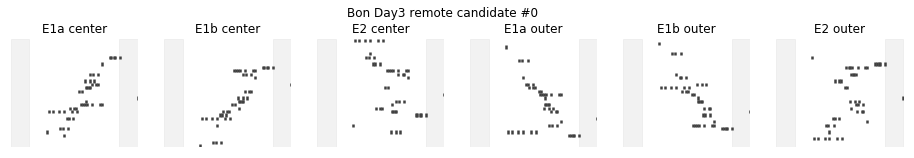

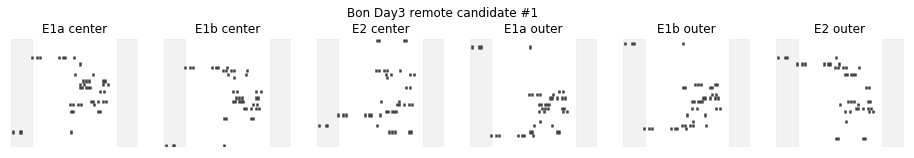

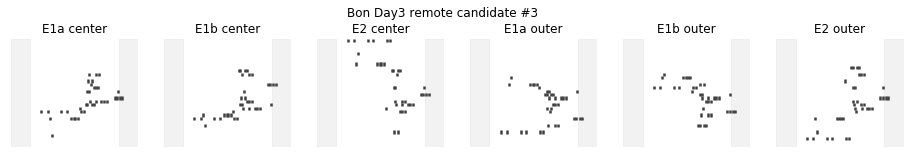

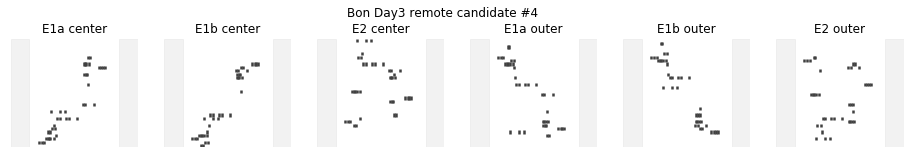

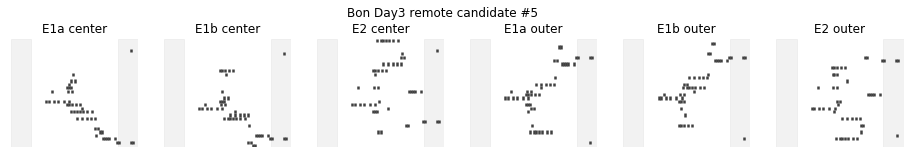

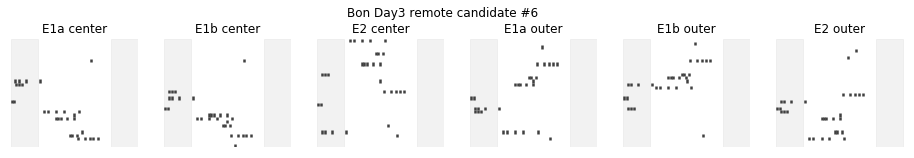

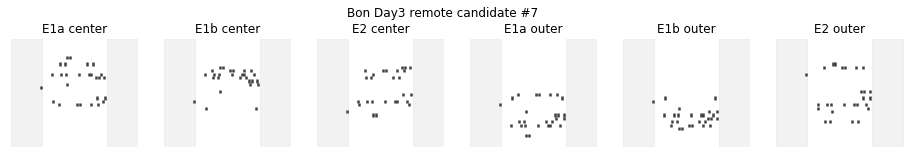

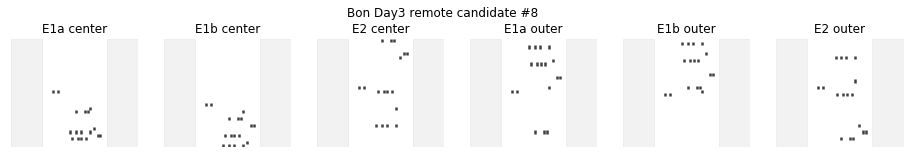

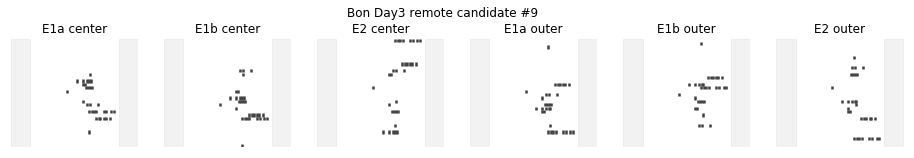

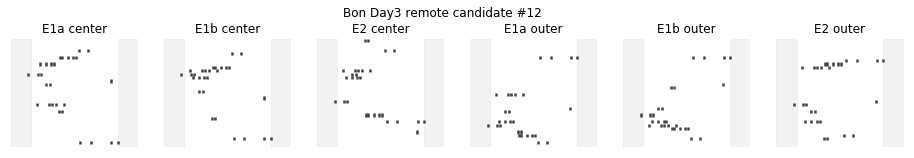

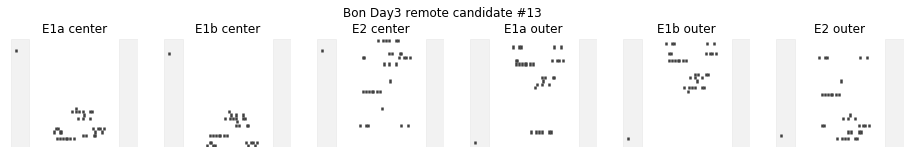

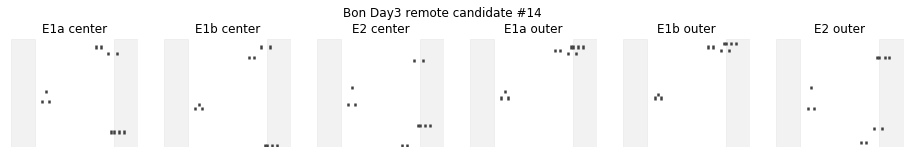

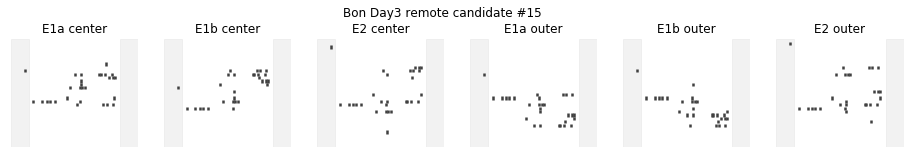

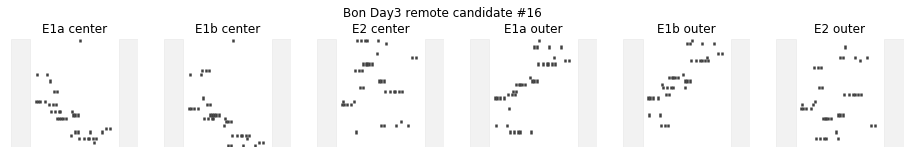

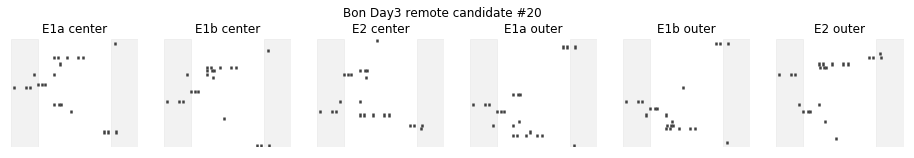

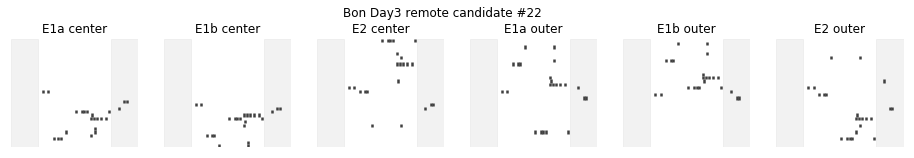

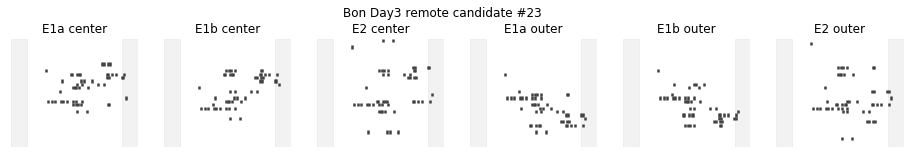

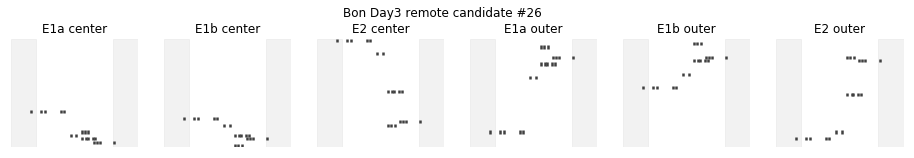

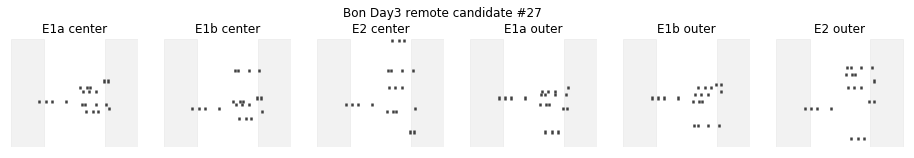

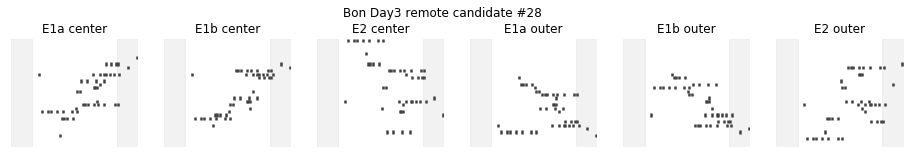

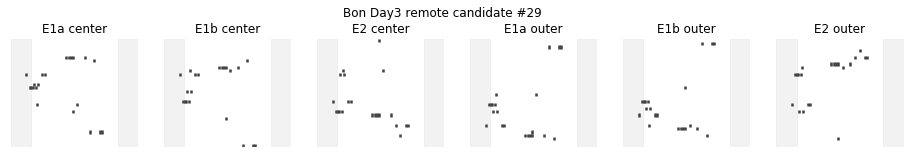

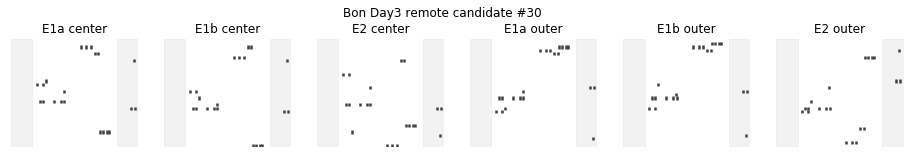

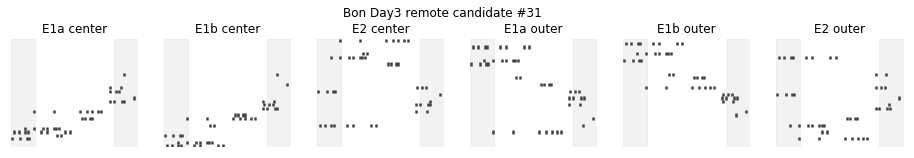

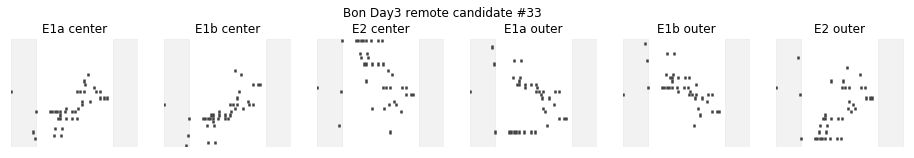

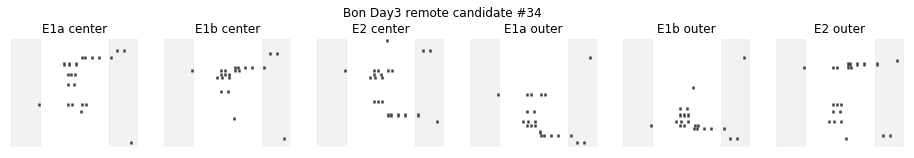

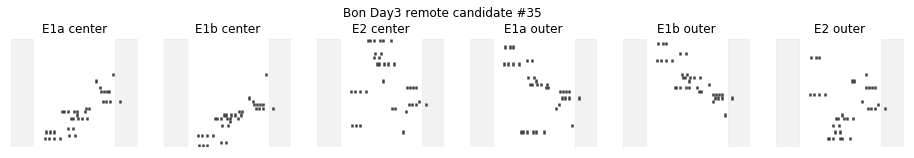

In [19]:
sig_thresh = 0.05

E1a, E1b, E2 = 1, 3, 5
animal = 'Bon'
day = 'Day3'

def plot_all_significant_linearized_E2_remote_events(data, animal, day):
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']
    except KeyError:
        raise UserWarning('The (animal, day) pair does not have remote replay analysis results...')
        return
    
    tc_E1a_co = data[animal][day]['tuning_curves1D_center'][E1a]
    tc_E1b_co = data[animal][day]['tuning_curves1D_center'][E1b]
    tc_E2_co = data[animal][day]['tuning_curves1D_center'][E2]
    
    tc_E1a_oo = data[animal][day]['tuning_curves1D_outer'][E1a]
    tc_E1b_oo = data[animal][day]['tuning_curves1D_outer'][E1b]
    tc_E2_oo = data[animal][day]['tuning_curves1D_outer'][E2]
    
    pvals = data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_hmm']
    sig_idx = np.argwhere(pvals < sig_thresh).squeeze().tolist()
    
    for evt_idx in sig_idx:
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 2))
        axes = (ax1, ax2, ax3, ax4, ax5, ax6)
        
        evt = bst[evt_idx]
        evt_extent = evt.support
        plot_extent = evt_extent.expand(0.05)
        
        st = data[animal][day]['remote_replay_E1_in_E2']['st_placecells_remote'][plot_extent]
        
        peak_order = tc_E1a_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax1)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax1)
        ax1.set_xlim(*st.support.time)
        ax1.set_title('E1a center')

        peak_order = tc_E1b_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax2)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax2)
        ax2.set_xlim(*st.support.time)
        ax2.set_title('E1b center')
        
        peak_order = tc_E2_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax3)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax3)
        ax3.set_xlim(*st.support.time)
        ax3.set_title('E2 center')

        peak_order = tc_E1a_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax4)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax4)
        ax4.set_xlim(*st.support.time)
        ax4.set_title('E1a outer')
        
        peak_order = tc_E1b_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax5)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax5)
        ax5.set_xlim(*st.support.time)
        ax5.set_title('E1b outer')
        
        peak_order = tc_E2_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax6)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax6)
        ax6.set_xlim(*st.support.time)
        ax6.set_title('E2 outer')
        
        fig.suptitle('{} {} remote candidate #{}'.format(animal, day, evt_idx), y=1.1)
        
        for ax in axes:
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)
            
        plt.show()

plot_all_significant_linearized_E2_remote_events(data=data, 
                         animal=animal,
                         day=day)

Notes: 13 ran back and forth on center arm (good to show trajectory, since local is all messed up)

14 truly messed up

15 _could_ make sense

20 seems plausible

22 is good in ONLY E1a-raw

29, 30 are fails

33 only bad in E1a-ideal



### Save augmented data

In [57]:
FrankLabData = nel.ResultsContainer(data=data,
                                    sessions=FrankLabData.sessions,
                                    cellinfo=FrankLabData.cellinfo,
                                    taskinfo=FrankLabData.taskinfo,
                                    tetinfo=FrankLabData.tetinfo,
                                    description=FrankLabData.description)

FrankLabData.save_pkl(fileroot + 'FrankLabData-BonConFra-no-eeg06d.nel')

To try:
- different training ds
- E1a and E1b seperately
- scaling of E2 SWR sequences?
- scaling Lambda mat?